In [9]:
pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/tmp/ipython-input-37064637.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_df["Mean_Rainfall"] = rainfall_df.mean(axis=1)


            Mean_Rainfall  Mean_Runoff  Mean_Discharge_Excl_Hirakud  \
Date                                                                  
1995-06-06       0.102154          0.0                    17.489273   
1995-06-07       0.014382          0.0                    19.961545   
1995-06-08       0.000000          0.0                    13.558364   
1995-06-09       0.006396          0.0                    17.906909   
1995-06-10       0.245008          0.0                    13.355182   

            Target_Hirakud_Inflow  
Date                               
1995-06-06                    0.0  
1995-06-07                    0.0  
1995-06-08                    0.0  
1995-06-09                    0.0  
1995-06-10                    0.0  
X_seq shape: (2426, 10, 3)


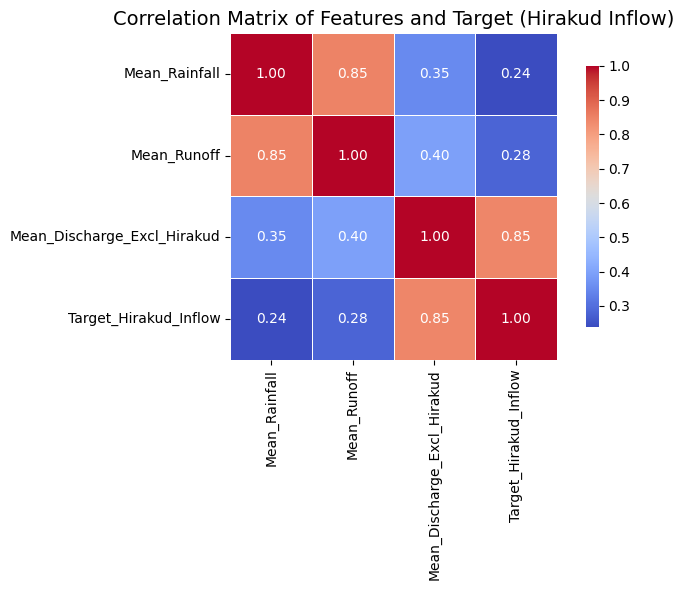

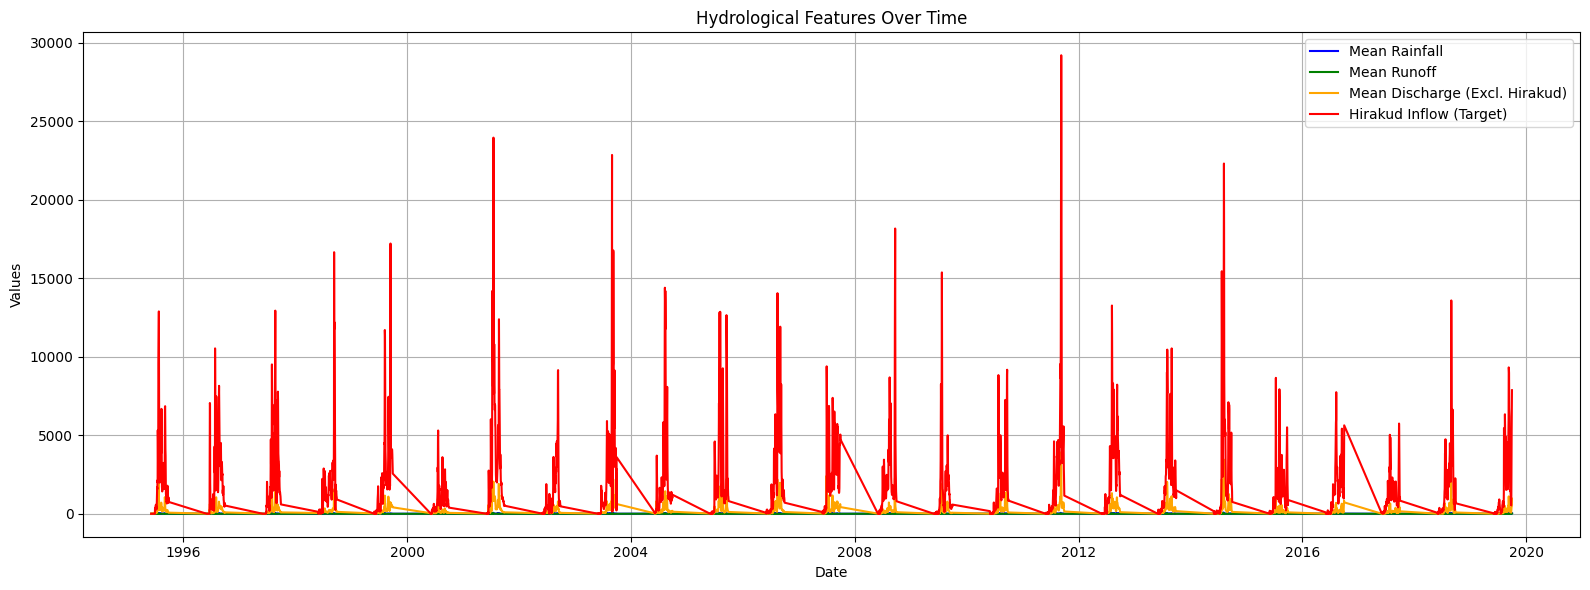

In [10]:
import pandas as pd

rainfall_df = pd.read_csv("/content/rainfall_with_dates.csv", parse_dates=["Date"], index_col="Date")
runoff_df = pd.read_csv("/content/runoff_with_dates.csv", parse_dates=["Date"], index_col="Date")
discharge_df = pd.read_csv("/content/discharge_with_dates.csv", parse_dates=["Date"], index_col="Date")

rainfall_df = rainfall_df.iloc[5:]
discharge_df = discharge_df.iloc[5:]

rainfall_df["Mean_Rainfall"] = rainfall_df.mean(axis=1)
runoff_df["Mean_Runoff"] = runoff_df.mean(axis=1)

discharge_df["Mean_Discharge_Excl_Hirakud"] = discharge_df.drop(columns="Hirakud").mean(axis=1)

combined_df = pd.DataFrame({
    "Mean_Rainfall": rainfall_df["Mean_Rainfall"],
    "Mean_Runoff": runoff_df["Mean_Runoff"],
    "Mean_Discharge_Excl_Hirakud": discharge_df["Mean_Discharge_Excl_Hirakud"],
    "Target_Hirakud_Inflow": discharge_df["Hirakud"]
}).dropna()

print(combined_df.head())

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)
X = combined_df.drop(columns=["Target_Hirakud_Inflow"]).values
y = combined_df["Target_Hirakud_Inflow"].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 10
X_seq, y_seq = create_sequences(X_train, y_train, sequence_length)
print("X_seq shape:", X_seq.shape)

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = combined_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title("Correlation Matrix of Features and Target (Hirakud Inflow)", fontsize=14)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

combined_df.reset_index(inplace=True)

plt.figure(figsize=(16, 6))

plt.plot(combined_df['Date'], combined_df['Mean_Rainfall'], label='Mean Rainfall', color='blue')
plt.plot(combined_df['Date'], combined_df['Mean_Runoff'], label='Mean Runoff', color='green')
plt.plot(combined_df['Date'], combined_df['Mean_Discharge_Excl_Hirakud'], label='Mean Discharge (Excl. Hirakud)', color='orange')
plt.plot(combined_df['Date'], combined_df['Target_Hirakud_Inflow'], label='Hirakud Inflow (Target)', color='red')

plt.title('Hydrological Features Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import torch
import torch.nn as nn

# ODE function
class ODEF(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.linear1 = nn.Linear(hidden_channels, 64)
        self.relu = nn.Tanh()
        self.linear2 = nn.Linear(64, hidden_channels)

    def forward(self, t, h):
        return self.linear2(self.relu(self.linear1(h)))

# ODE-RNN Model
class ODERNN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.rnn_cell = nn.GRUCell(input_channels, hidden_channels)
        self.odefunc = ODEF(hidden_channels)
        self.readout = nn.Linear(hidden_channels, output_channels)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_channels).to(x.device)
        t = torch.linspace(0, 1, seq_len).to(x.device)

        for i in range(seq_len):
            if i > 0:
                # Evolve hidden state using ODE
                t_span = t[i-1:i+1]
                h = odeint(self.odefunc, h, t_span)[-1]  # take h at t[i]
            h = self.rnn_cell(x[:, i, :], h)

        return self.readout(h)  # use final hidden state

In [12]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
train_dataset = TimeSeriesDataset(X_seq, y_seq)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Model setup
input_channels = X_seq.shape[2]
hidden_channels = 64
output_channels = 1
model = ODERNN(input_channels, hidden_channels, output_channels)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/50, Loss: 0.0069
Epoch 2/50, Loss: 0.0025
Epoch 3/50, Loss: 0.0019
Epoch 4/50, Loss: 0.0017
Epoch 5/50, Loss: 0.0015
Epoch 6/50, Loss: 0.0014
Epoch 7/50, Loss: 0.0014
Epoch 8/50, Loss: 0.0013
Epoch 9/50, Loss: 0.0013
Epoch 10/50, Loss: 0.0013
Epoch 11/50, Loss: 0.0012
Epoch 12/50, Loss: 0.0012
Epoch 13/50, Loss: 0.0012
Epoch 14/50, Loss: 0.0012
Epoch 15/50, Loss: 0.0012
Epoch 16/50, Loss: 0.0012
Epoch 17/50, Loss: 0.0011
Epoch 18/50, Loss: 0.0011
Epoch 19/50, Loss: 0.0011
Epoch 20/50, Loss: 0.0011
Epoch 21/50, Loss: 0.0011
Epoch 22/50, Loss: 0.0011
Epoch 23/50, Loss: 0.0011
Epoch 24/50, Loss: 0.0011
Epoch 25/50, Loss: 0.0011
Epoch 26/50, Loss: 0.0011
Epoch 27/50, Loss: 0.0011
Epoch 28/50, Loss: 0.0011
Epoch 29/50, Loss: 0.0011
Epoch 30/50, Loss: 0.0010
Epoch 31/50, Loss: 0.0011
Epoch 32/50, Loss: 0.0011
Epoch 33/50, Loss: 0.0010
Epoch 34/50, Loss: 0.0010
Epoch 35/50, Loss: 0.0012
Epoch 36/50, Loss: 0.0010
Epoch 37/50, Loss: 0.0010
Epoch 38/50, Loss: 0.0010
Epoch 39/50, Loss: 0.

RMSE: 740.769
NSE: 0.835
KGE: 0.842
RPE: 0.117
PTE: 0 time steps


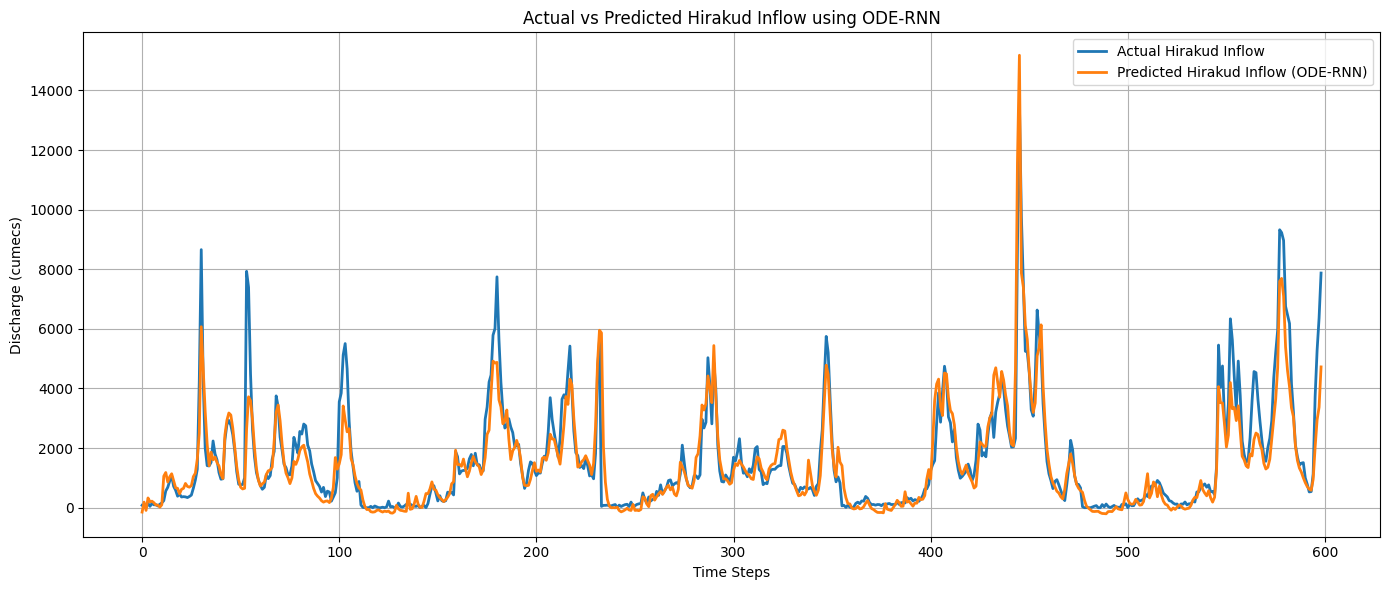

In [14]:
from sklearn.metrics import mean_squared_error
# Prepare test sequences
X_seq_test, y_seq_test = create_sequences(X_test, y_test, sequence_length)
X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    preds = model(X_seq_test)

y_pred_rescaled = scaler_y.inverse_transform(preds.numpy())
y_true_rescaled = scaler_y.inverse_transform(y_seq_test.numpy())

# Evaluation Metrics
def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

def kge(y_true, y_pred):
    r = np.corrcoef(y_true.squeeze(), y_pred.squeeze())[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

def rpe(y_true, y_pred):
    return np.abs(np.max(y_pred) - np.max(y_true)) / np.max(y_true)

def pte(y_true, y_pred):
    return np.argmax(y_pred) - np.argmax(y_true)

rmse = np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
nse_val = nse(y_true_rescaled, y_pred_rescaled)
kge_val = kge(y_true_rescaled, y_pred_rescaled)
rpe_val = rpe(y_true_rescaled, y_pred_rescaled)
pte_val = pte(y_true_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.3f}")
print(f"NSE: {nse_val:.3f}")
print(f"KGE: {kge_val:.3f}")
print(f"RPE: {rpe_val:.3f}")
print(f"PTE: {pte_val} time steps")

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_true_rescaled, label='Actual Hirakud Inflow', linewidth=2)
plt.plot(y_pred_rescaled, label='Predicted Hirakud Inflow (ODE-RNN)', linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Discharge (cumecs)")
plt.title("Actual vs Predicted Hirakud Inflow using ODE-RNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
